In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from icecream import ic

import emcee
import time
import corner

plt.rc('text', usetex=True)
plt.rc('font', family='STIXGeneral')

# Parameter fit: Bayesian inference with MCMC

In [2]:
# walkers and chains for all fits
nwalkers = 128
niter = 500

## Sodium at detector 1
As our model, we choose a sum of a lognormal distribution(Compton scattering) and two gaussian distributions (511keV and 1275keV)

\begin{align}
    M(\vec{\theta}, x) &= a_1 \cdot P_{logn}((\mu_1,\sigma_1),x) + a_2 \cdot P_{gauss}((\mu_2,\sigma_2), x) + a_3 \cdot P_{gauss}((\mu_3,\sigma_3), x) \\
    P_{logn}((\mu,\sigma), x) &= \frac{1}{x \cdot \sigma \sqrt{2\pi}} \exp \left[ -\frac{1}{2} \left ( \frac{\ln x - \mu}{\sigma} \right )^2  \right] \\
    P_{gauss}((\mu,sigma), x) &= \frac{1}{\sigma \sqrt{2\pi}} \exp \left[ -\frac{1}{2} \left( \frac{x-\mu}{\sigma} \right)^2 \right ] \\
    \vec{\theta} &= (\mu_1, \mu_2, \mu_3, \sigma_1, \sigma_2, \sigma_3, a_1, a_2, a_3)^T
\end{align}

Starting burn-in period


/home/alex/.local/lib/python3.13/site-packages/pandas/core/indexes/base.py:945: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*new_inputs, **kwargs)


Burn-in period complete
Starting chains
...Complete!
Time required:   72.43301200866699


/home/alex/.local/lib/python3.13/site-packages/pandas/core/indexes/base.py:945: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*new_inputs, **kwargs)


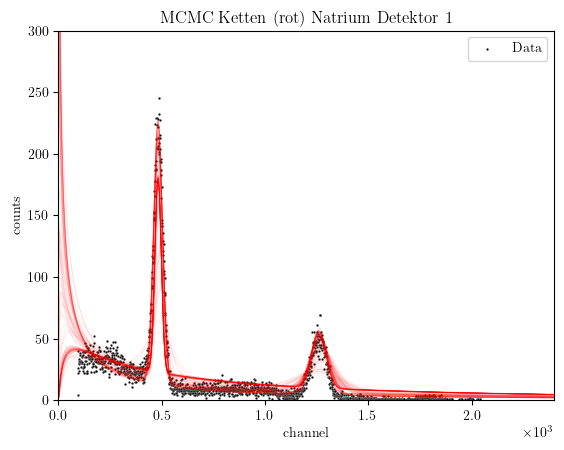

/home/alex/.local/lib/python3.13/site-packages/pandas/core/indexes/base.py:945: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*new_inputs, **kwargs)


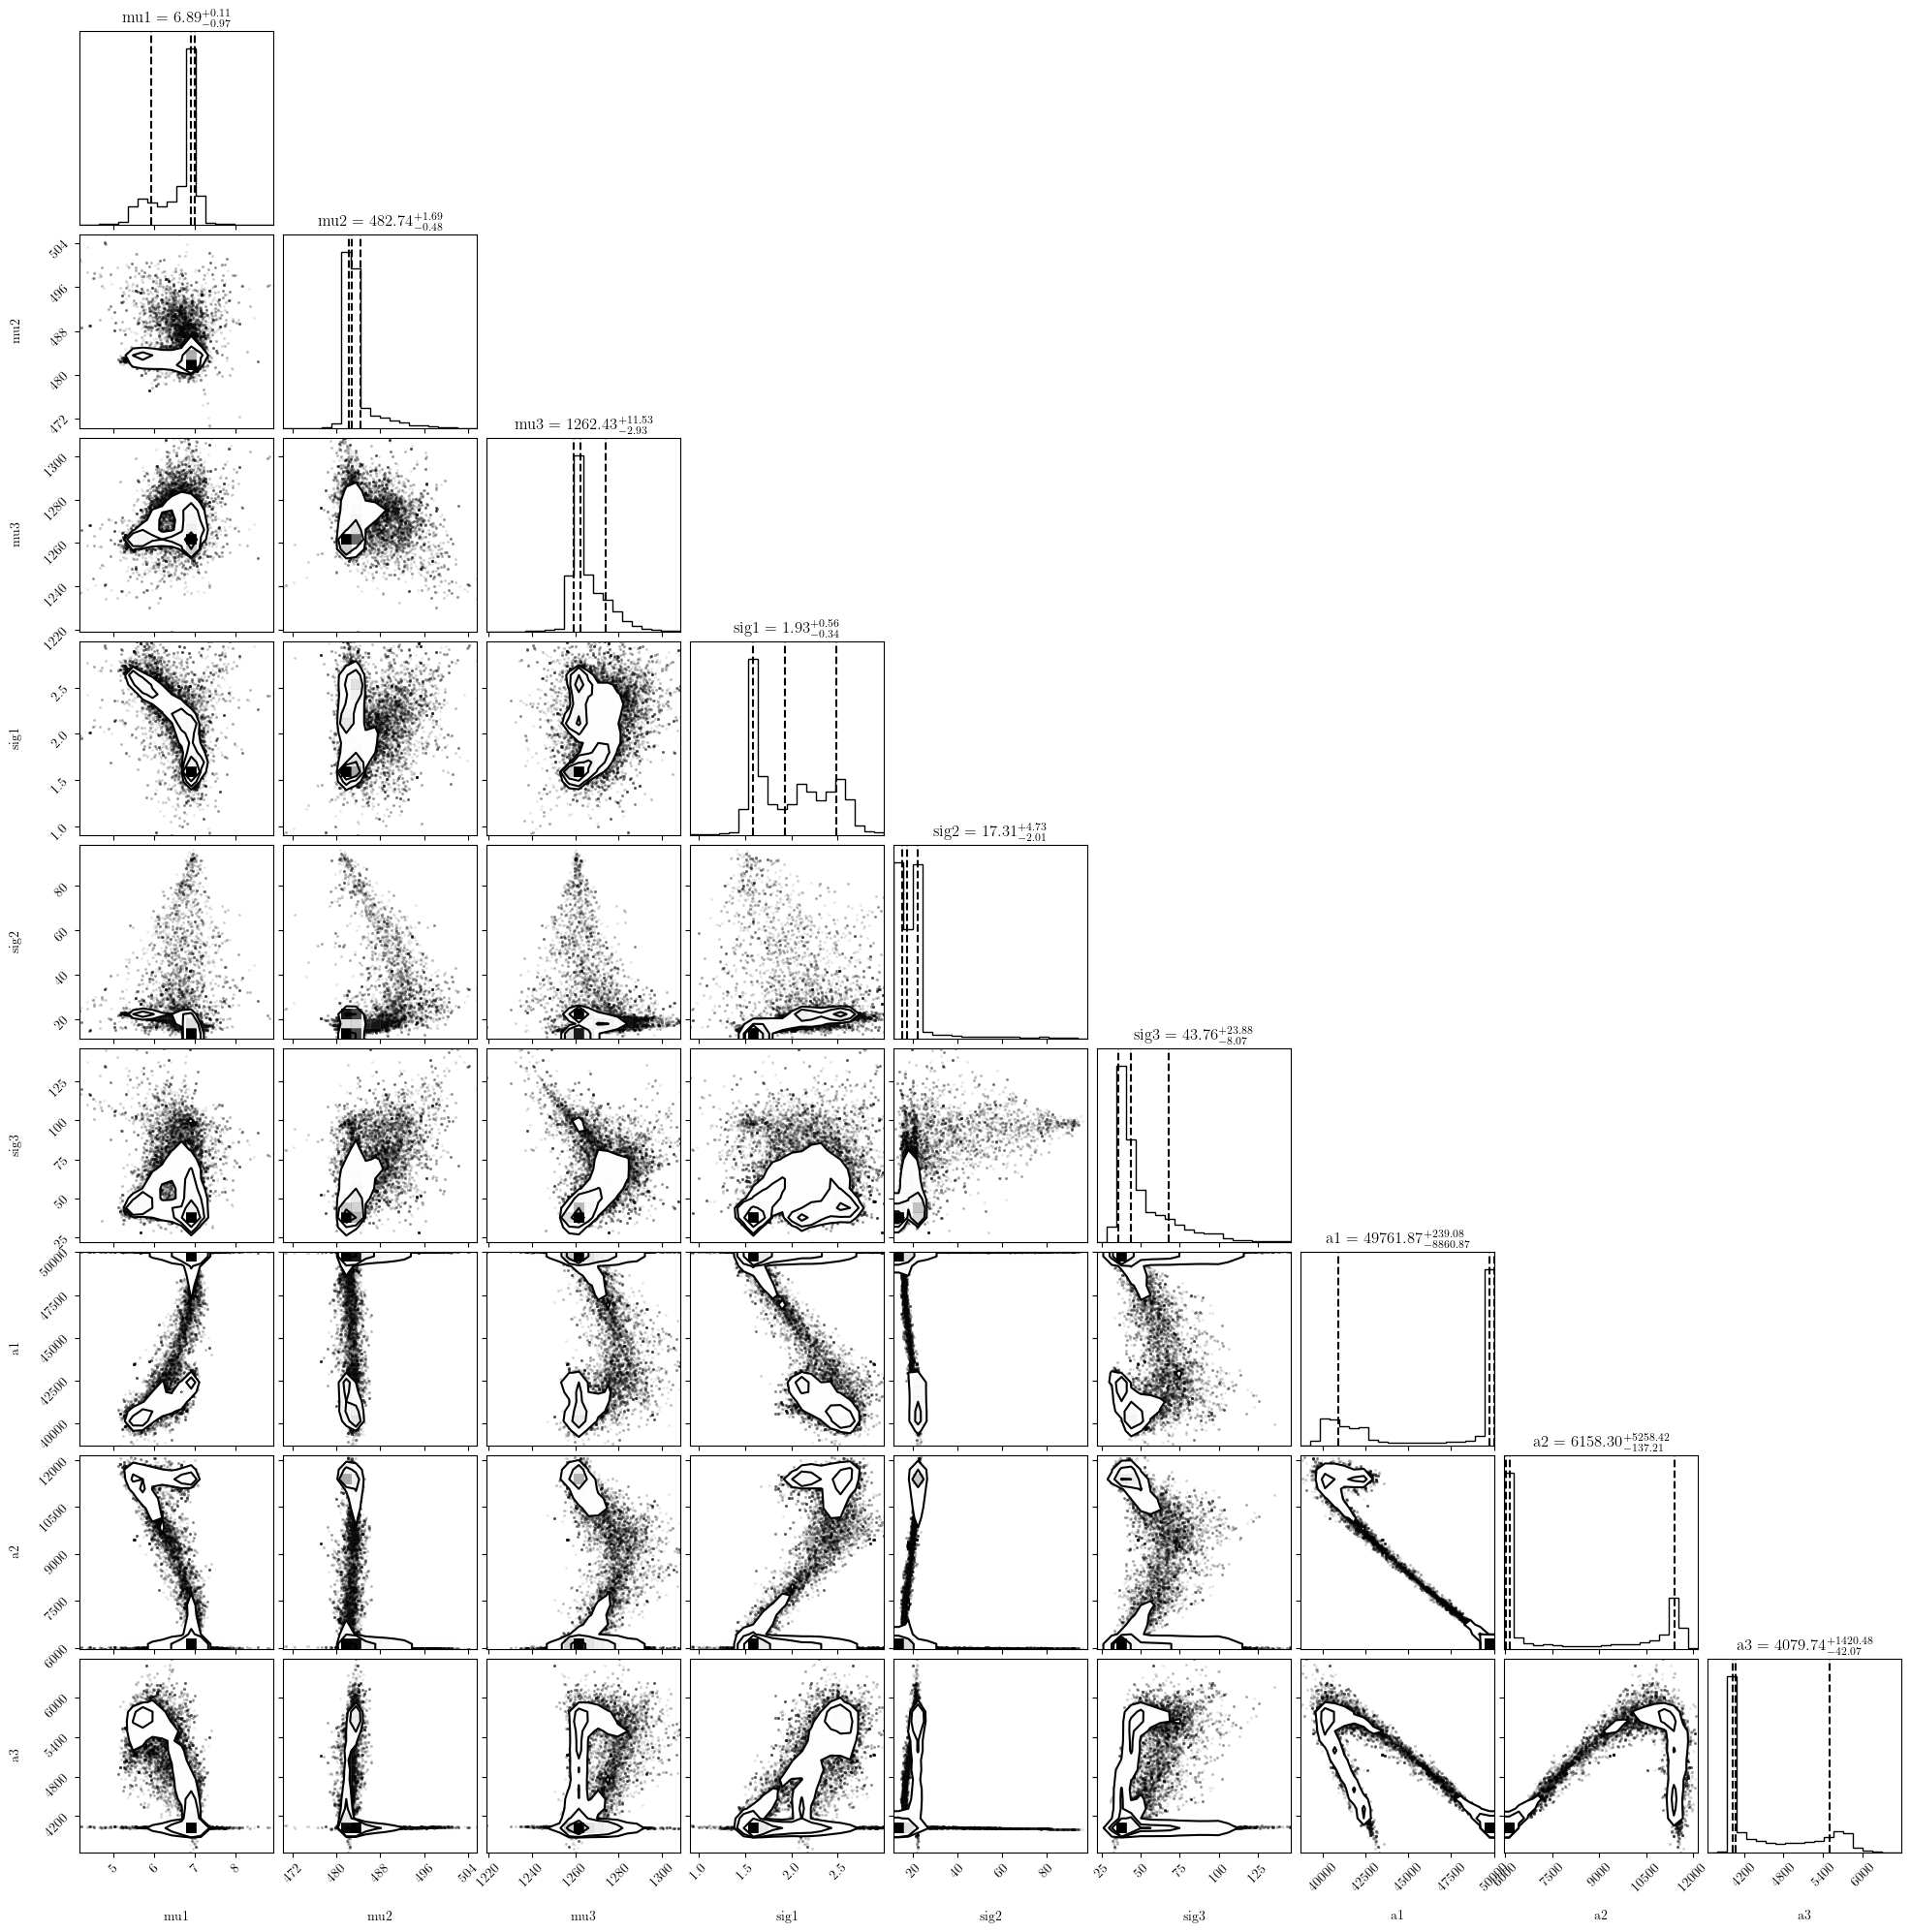

/home/alex/.local/lib/python3.13/site-packages/pandas/core/indexes/base.py:945: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*new_inputs, **kwargs)


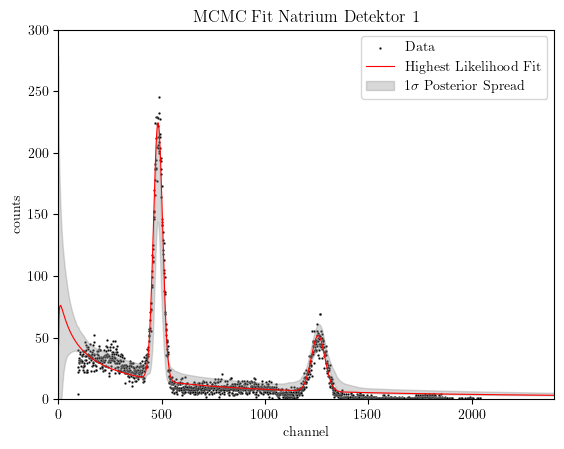

Hyperparameter: 
 [7.01209719e+00 4.82416601e+02 1.25704980e+03 2.17453966e+00
 2.19667443e+01 3.28903501e+01 4.32648721e+04 1.15116317e+04
 3.73078523e+03]


In [3]:
# reading data
df = pd.read_csv('Results/energiespektrum_natrium_detektor1.asc')
df.columns = ['counts']
df.index.name = 'channel'
df['counts'] = df.loc[df['counts'] > 0]

#------------------------------------------------------------------------------------------------------------
# model building

def model(theta,ch=df.index):
    # mu0, mu1,mu2,mu3,sig0,sig1,sig2,sig3,a0,a1,a2,a3 = theta
    mu0,mu2,mu3,sig0,sig2,sig3,a0,a2,a3 = theta
    lognormal0 = np.divide(1,ch*sig0*np.sqrt(2*np.pi)) * np.exp(-np.divide(np.power(np.log(ch)-mu0,2),2*sig0**2))
    # gaussian1 = np.divide(1,sig1*np.sqrt(2*np.pi)) * np.exp(-(ch-mu1)**2 / (2*sig1**2) )
    gaussian2 = np.divide(1,sig2*np.sqrt(2*np.pi)) * np.exp(- ( (ch-mu2) /sig2 )**2 / 2)
    gaussian3 = np.divide(1,sig3*np.sqrt(2*np.pi)) * np.exp(- ( (ch-mu3) /sig3 )**2 / 2)
    return a0*lognormal0 + a2*gaussian2 + a3*gaussian3 

def lnlike(theta, ch, value, value_err):
    return -0.5 * np.sum(((value - model(theta, ch))/value_err) ** 2)

def lnprior(theta):
    # mu0,mu1,mu2,mu3,sig0,sig1,sig2,sig3,a0,a1,a2,a3 = theta
    mu0,mu2,mu3,sig0,sig2,sig3,a0,a2,a3 = theta
    # if  0.0 < mu0 < 10.0 and 700.0 < mu1 < 1000.0 and 430.0 < mu2 < 530.0 and 1210.0 < mu3 < 1310.0 and 0.0 < sig0 < 3.0 and 400.0 < sig1 < 1000.0 and 0.0 < sig2 < 150.0 and 0.0 < sig3 < 150.0 and 1e4 < a0 < 1e5 and 1e4 < a1 < 3e4 and 0.0 < a2 < 250.0 and 0.0 < a3 < 80:
    #     return 0.0
    if  0.0 < mu0 < 10.0 and 430.0 < mu2 < 530.0 and 1210.0 < mu3 < 1310.0 and 0.0 < sig0 < 3.0 and 0.0 < sig2 < 150.0 and 0.0 < sig3 < 150.0 and 1e4 < a0 < 1e5 and 0.0 < a2 < 1.5e4 and 0.0 < a3 < 8e3:
        return 0.0
    return -np.inf

def lnprob(theta, ch, value, value_err):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, ch, value, value_err)

count_err = 0.05*df['counts'].mean() # arbitrary error bar; we may need to look at the precision of the TSCA
data = (df.index, df['counts'], count_err)
initial = np.array([7.0, 480.0, 1260.0, 1.0, 100.0, 100.0, 50000.0, 6000.0, 4000.0])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

def main(p0,nwalkers,niter,ndim,lnprob,data):
    start = time.time()
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)
    print("Starting burn-in period")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()
    print("Burn-in period complete")
    print("Starting chains") # this will take 1-5 minutes depending on the size of the walkers and iterations, about 60s for 128 walkers and 500 chains
    pos, prob, state = sampler.run_mcmc(p0, niter)
    print("...Complete!")
    
    end = time.time()
    print("Time required:  ",end - start)
    return sampler, pos, prob, state

sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

def mcmcplot(sampler,ch=df.index,val=df['counts']):
    plt.ion()
    sns.scatterplot(x=ch,y=val, s=3, color='k', label='Data')
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(ch, model(theta, ch), color="r", alpha=0.1, linewidth=.5)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('channel')
    plt.ylabel('counts')
    ax = plt.gca()
    ax.set_xlim([0,2400])
    ax.set_ylim([0,300])
    plt.title("MCMC Ketten (rot) Natrium Detektor 1")
    plt.legend()
    plt.savefig("plots/MCMC Natrium Detektor 1 Chains.pdf")
    plt.show()

mcmcplot(sampler)

samples = sampler.flatchain
hyperparameter_na1 = samples[np.argmax(sampler.flatlnprobability)] # fitted hyperparameter with best values
mcmcfit = model(hyperparameter_na1)

#------------------------------------------------------------------------------------------------------------
# diagnosis corner plot

labels = ['mu1','mu2','mu3','sig1','sig2','sig3','a1','a2','a3']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])
plt.savefig("plots/MCMC Natrium Detektor 1 Hyperparameters.pdf")
plt.show()
#------------------------------------------------------------------------------------------------------------
# result plot

def sample_walkers(nsamples,flattened_chain):
    models = []
    draw = np.floor(np.random.uniform(0,len(flattened_chain),size=nsamples)).astype(int)
    thetas = flattened_chain[draw]
    for i in thetas:
        mod = model(i)
        models.append(mod)
    spread = np.std(models,axis=0)
    med_model = np.median(models,axis=0)
    return med_model,spread
med_model, spread = sample_walkers(100,samples)

sns.scatterplot(x=df.index,y=df['counts'], s=3, color='k', label='Data')
plt.plot(df.index,mcmcfit, color='r',linewidth=.8, label='Highest Likelihood Fit')
plt.fill_between(df.index,med_model-spread,med_model+spread,color='grey',alpha=0.3,label=r'$1\sigma$ Posterior Spread')
plt.xlabel('channel')
plt.ylabel('counts')
ax = plt.gca()
ax.set_xlim([0,2400])
ax.set_ylim([0,300])
plt.title("MCMC Fit Natrium Detektor 1")
plt.legend()
plt.savefig("plots/MCMC Natrium Detektor 1 Fit.pdf")
plt.show()
print('Hyperparameter: \n',hyperparameter_na1)

## Sodium at detector 2
Similar model as before: one lognormal distribution and two gaussian distributions. Here, we include one more parameter, $b_1$, to look for optimal peak for the lognormal distribution:
$$
    P_{logn}((a,b,\mu,\sigma), x) = a \cdot \frac{1}{(x-b) \cdot \sigma \sqrt{2\pi}} \exp \left[ -\frac{1}{2} \left ( \frac{\ln (x-b) - \mu}{\sigma} \right )^2  \right]
$$

Starting burn-in period


/home/alex/.local/lib/python3.13/site-packages/pandas/core/indexes/base.py:945: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*new_inputs, **kwargs)


Burn-in period complete
Starting chains
...Complete!
Time required:   68.3868362903595


/home/alex/.local/lib/python3.13/site-packages/pandas/core/indexes/base.py:945: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*new_inputs, **kwargs)


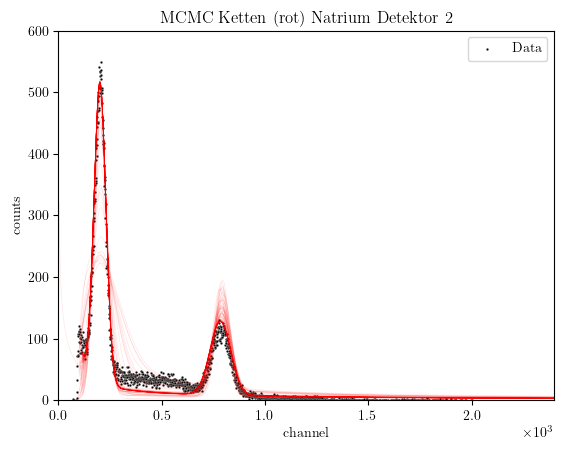

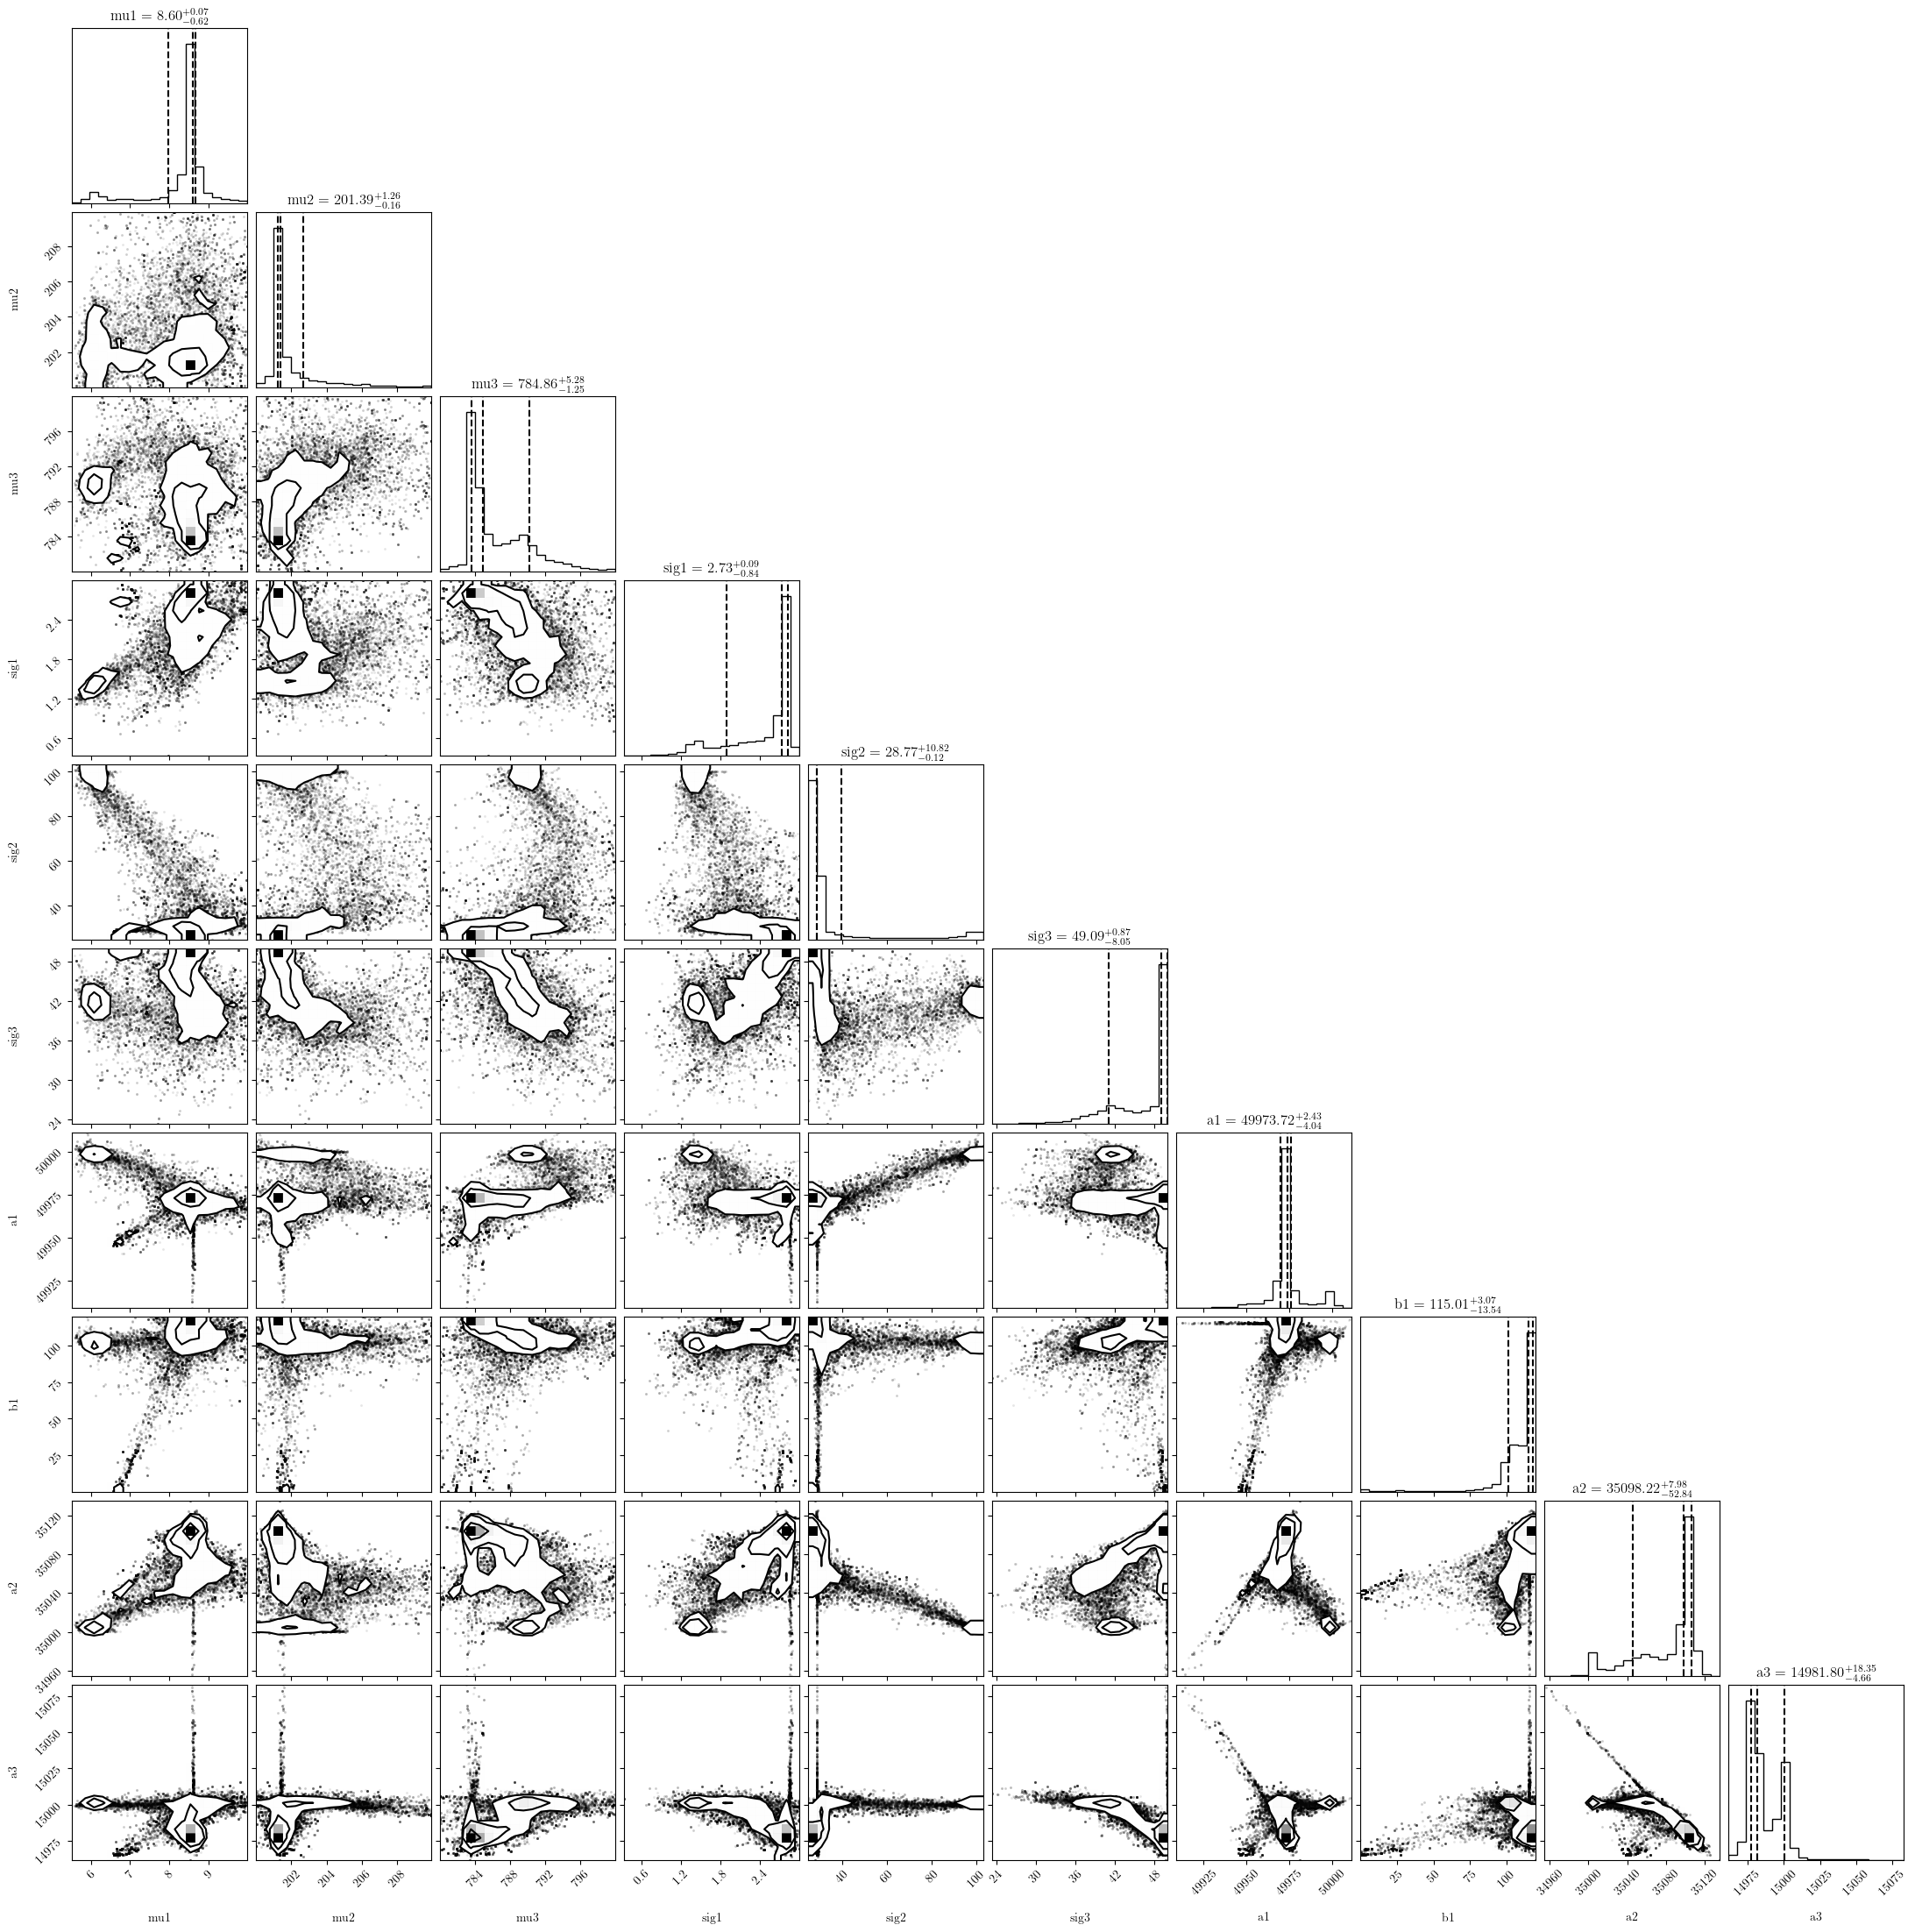

/home/alex/.local/lib/python3.13/site-packages/pandas/core/indexes/base.py:945: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*new_inputs, **kwargs)


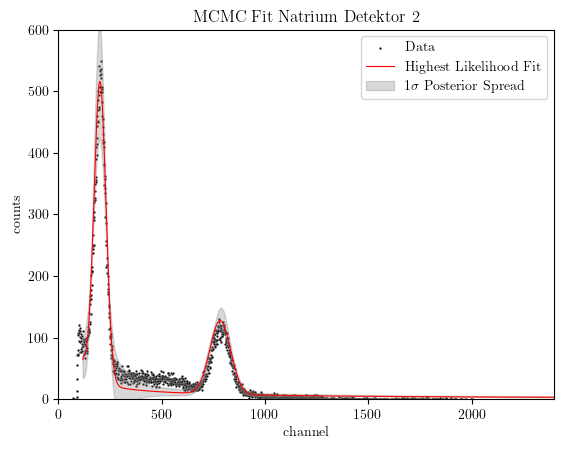

Hyperparameter: 
 [8.63520455e+00 2.01397352e+02 7.83274585e+02 2.77204017e+00
 2.86676680e+01 4.99970940e+01 4.99757580e+04 1.18019747e+02
 3.50970798e+04 1.49819575e+04]


In [4]:
# reading data
df = pd.read_csv('Results/energiespektrum_natrium_detektor2.asc')
df.columns = ['counts']
df.index.name = 'channel'
df['counts'] = df.loc[df['counts'] > 0]

#------------------------------------------------------------------------------------------------------------
# model building

def model(theta,ch=df.index):
    mu1,mu2,mu3,sig1,sig2,sig3,a1,b1,a2,a3 = theta
    lognormal1 = np.divide(1,(ch-b1)*sig1*np.sqrt(2*np.pi)) * np.exp(-np.divide(np.power(np.log(ch-b1)-mu1,2),2*sig1**2))
    gaussian2 = np.divide(1,sig2*np.sqrt(2*np.pi)) * np.exp(- ( (ch-mu2) /sig2 )**2 / 2)
    gaussian3 = np.divide(1,sig3*np.sqrt(2*np.pi)) * np.exp(- ( (ch-mu3) /sig3 )**2 / 2)
    return a1*lognormal1 + a2*gaussian2 + a3*gaussian3 

def lnlike(theta, ch, value, value_err):
    return -0.5 * np.sum(((value - model(theta, ch))/value_err) ** 2)

def lnprior(theta):
    mu1,mu2,mu3,sig1,sig2,sig3,a1,b1,a2,a3 = theta
    if 0.0 < mu1 < 10.0 and 200.0 < mu2 < 210.0 and 780.0 < mu3 < 800.0 and 0.0 < sig1 < 3.0 and 0.0 < sig2 < 150.0 and 0.0 < sig3 < 50.0 and 1e4 < a1 < 7e4 and 0.0 < b1 < 120.0 and 0.0 < a2 < 5e4 and 0.0 < a3 < 4e4:
        return 0.0
    return -np.inf

def lnprob(theta, ch, value, value_err):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, ch, value, value_err)

count_err = 0.05*df['counts'].mean() # arbitrary error bar; we may need to look at the precision of the TSCA
data = (df.index, df['counts'], count_err)
initial = np.array([7.0, 205.0, 790.0, 2.3, 100.0, 40.0, 50000.0, 100.0 , 3.5e4, 1.5e4])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

def main(p0,nwalkers,niter,ndim,lnprob,data):
    start = time.time()
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)
    print("Starting burn-in period")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()
    print("Burn-in period complete")
    print("Starting chains") # this will take 1-5 minutes depending on the size of the walkers and iterations
    pos, prob, state = sampler.run_mcmc(p0, niter)
    print("...Complete!")
    
    end = time.time()
    print("Time required:  ",end - start)
    return sampler, pos, prob, state

sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

def mcmcplot(sampler,ch=df.index,val=df['counts']):
    plt.ion()
    sns.scatterplot(x=ch,y=val, s=3, color='k', label='Data')
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(ch, model(theta, ch), color="r", alpha=0.1, linewidth=.5)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('channel')
    plt.ylabel('counts')
    ax = plt.gca()
    ax.set_xlim([0,2400])
    ax.set_ylim([0,600])
    plt.title("MCMC Ketten (rot) Natrium Detektor 2")
    plt.legend()
    plt.savefig("plots/MCMC Natrium Detektor 2 Chains.pdf")
    plt.show()

mcmcplot(sampler)

samples = sampler.flatchain
hyperparameter_na2 = samples[np.argmax(sampler.flatlnprobability)] # fitted hyperparameter with best values
mcmcfit = model(hyperparameter_na2)

#------------------------------------------------------------------------------------------------------------
# diagnosis corner plot

labels = ['mu1','mu2','mu3','sig1','sig2','sig3','a1','b1','a2','a3']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])
plt.savefig("plots/MCMC Natrium Detektor 2 Hyperparameters.pdf")
plt.show()

#------------------------------------------------------------------------------------------------------------
# result plot

def sample_walkers(nsamples,flattened_chain):
    models = []
    draw = np.floor(np.random.uniform(0,len(flattened_chain),size=nsamples)).astype(int)
    thetas = flattened_chain[draw]
    for i in thetas:
        mod = model(i)
        models.append(mod)
    spread = np.std(models,axis=0)
    med_model = np.median(models,axis=0)
    return med_model,spread
med_model, spread = sample_walkers(100,samples)

sns.scatterplot(x=df.index,y=df['counts'], s=3, color='k', label='Data')
plt.plot(df.index,mcmcfit, color='r',linewidth=.8, label='Highest Likelihood Fit')
plt.fill_between(df.index,med_model-spread,med_model+spread,color='grey',alpha=0.3,label=r'$1\sigma$ Posterior Spread')
plt.xlabel('channel')
plt.ylabel('counts')
ax = plt.gca()
ax.set_xlim([0,2400])
ax.set_ylim([0,600])
plt.title("MCMC Fit Natrium Detektor 2")
plt.legend()
plt.savefig("plots/MCMC Natrium Detektor 2 Fit.pdf")
plt.show()
print('Hyperparameter: \n',hyperparameter_na2)

## Cobalt at detector 1

Starting burn-in period


/home/alex/.local/lib/python3.13/site-packages/pandas/core/indexes/base.py:945: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
/home/alex/.local/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Burn-in period complete
Starting chains
...Complete!
Time required:   75.0449001789093


/home/alex/.local/lib/python3.13/site-packages/pandas/core/indexes/base.py:945: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*new_inputs, **kwargs)


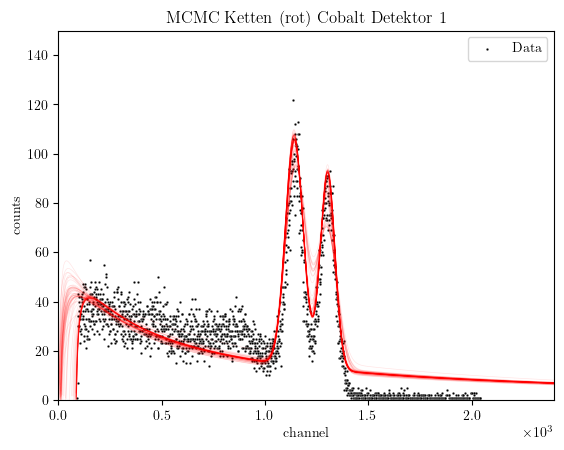

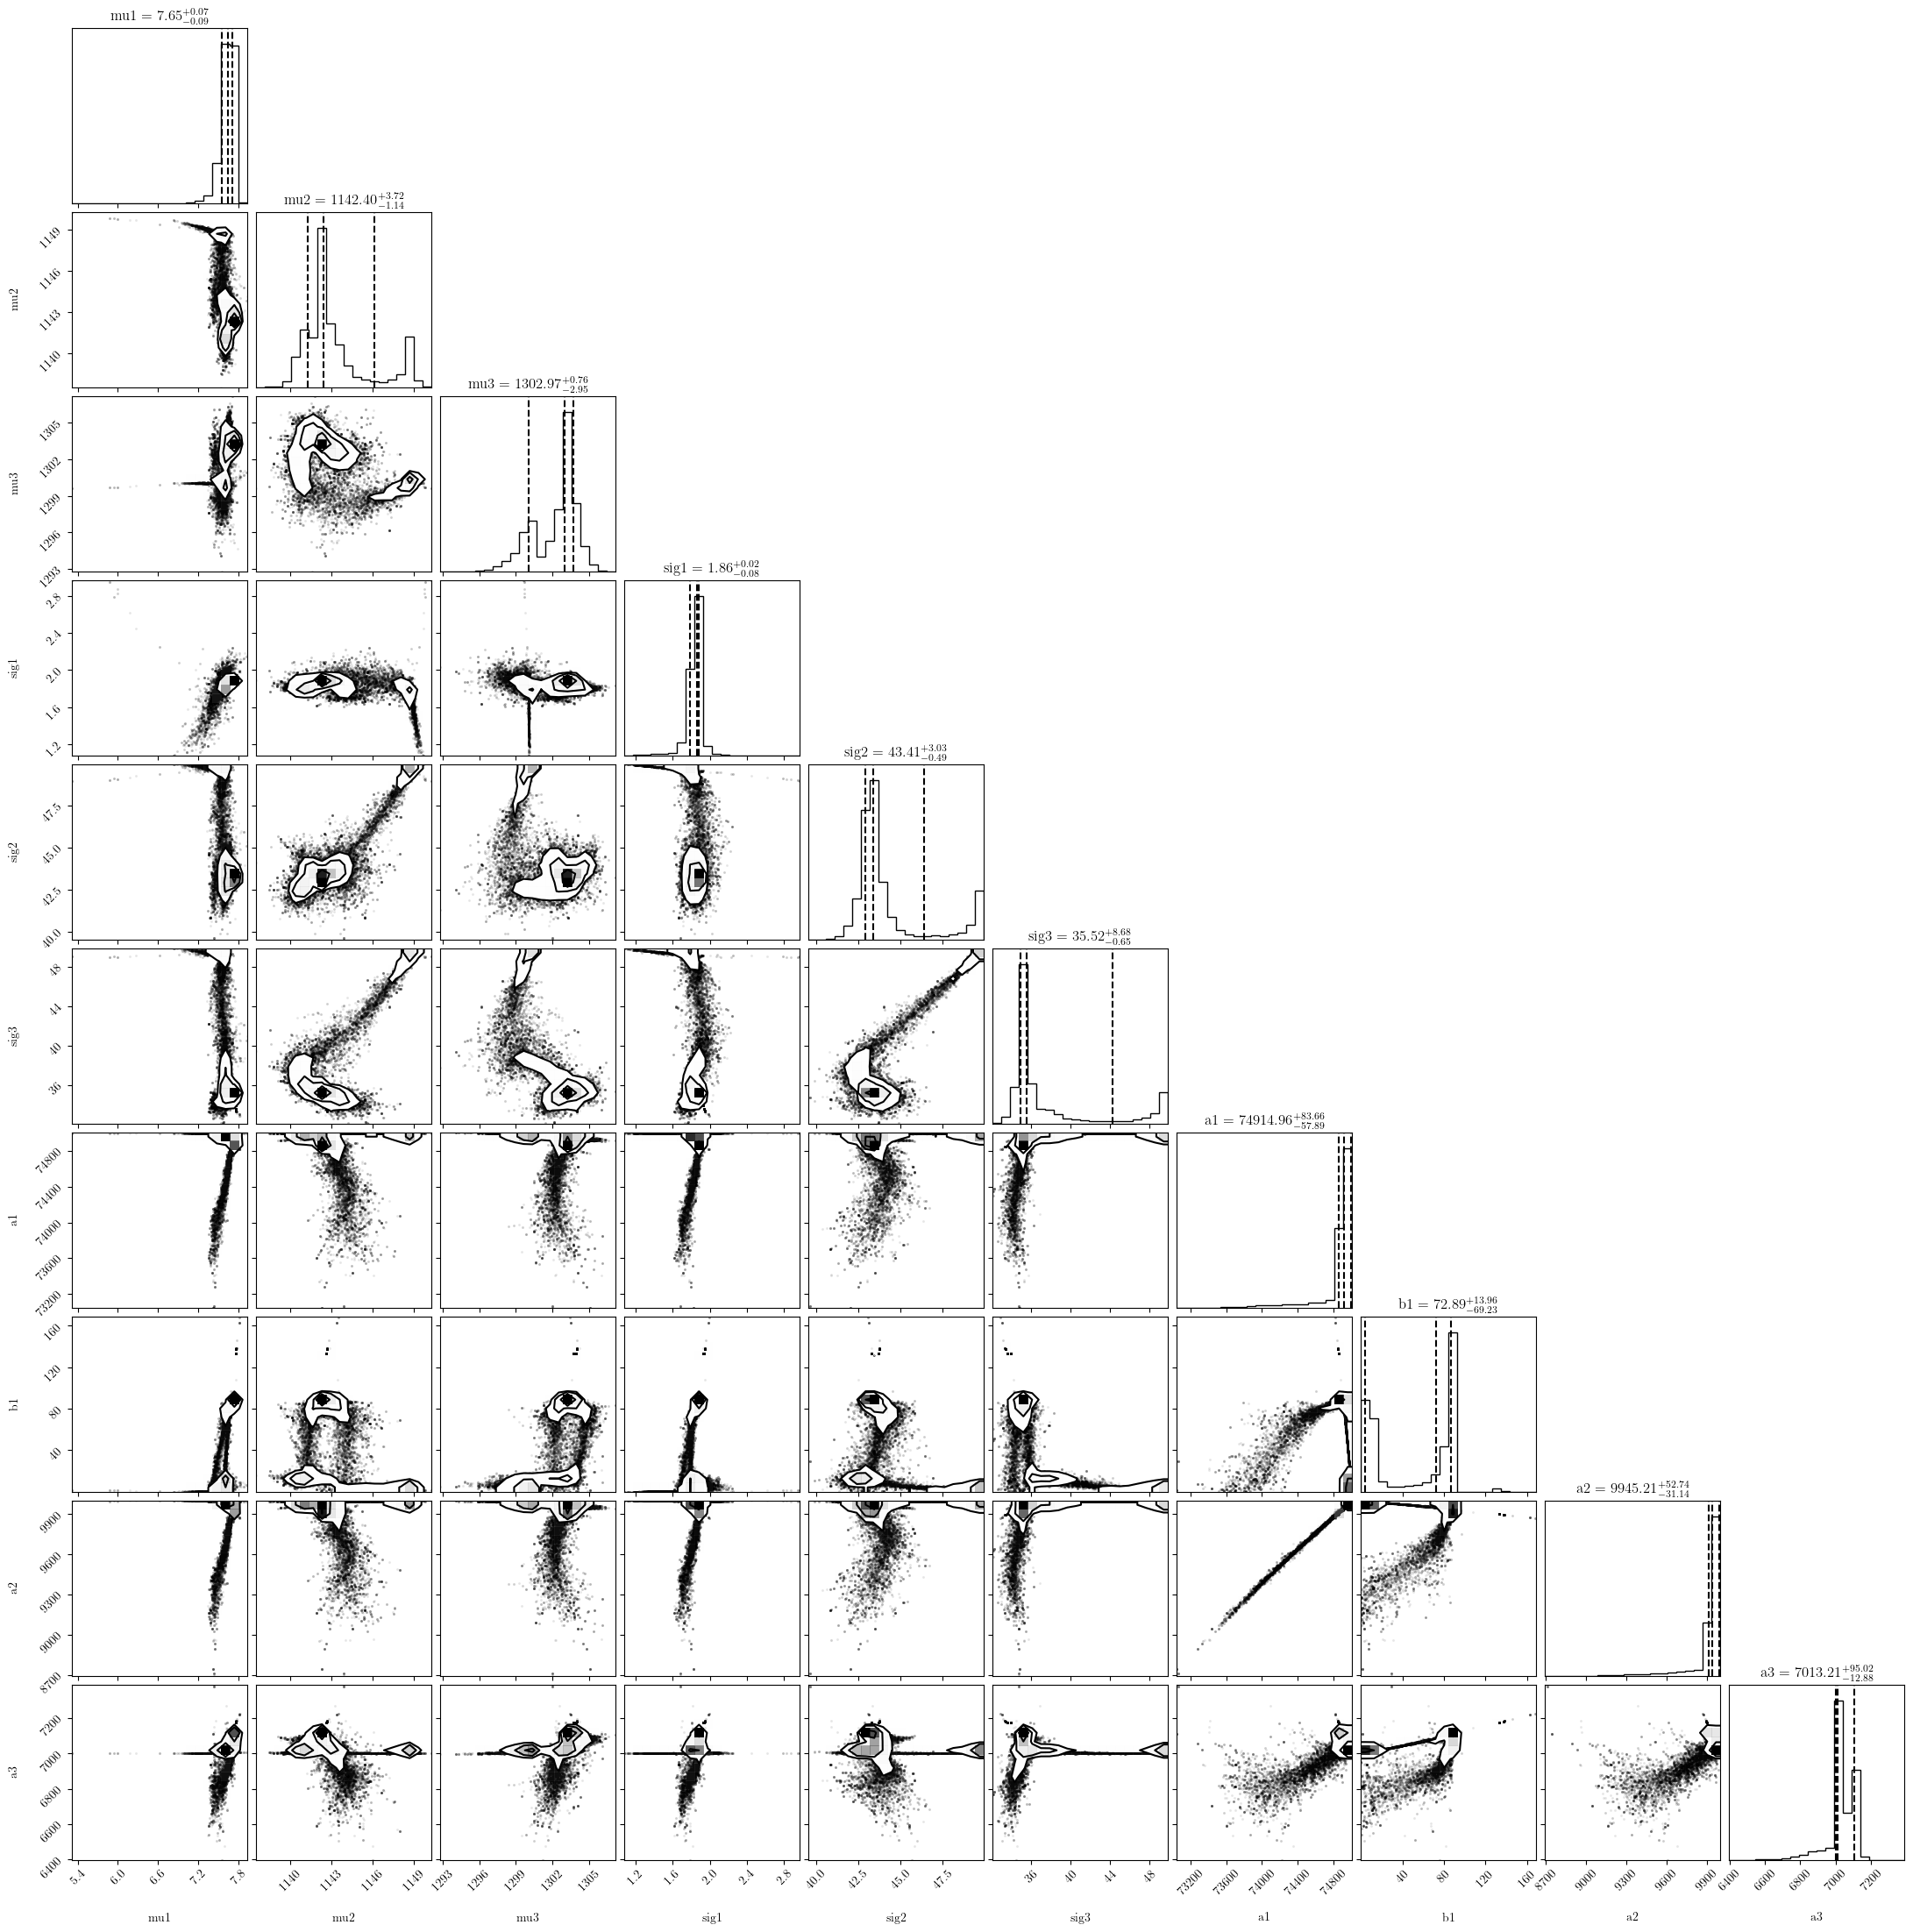

/home/alex/.local/lib/python3.13/site-packages/pandas/core/indexes/base.py:945: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*new_inputs, **kwargs)


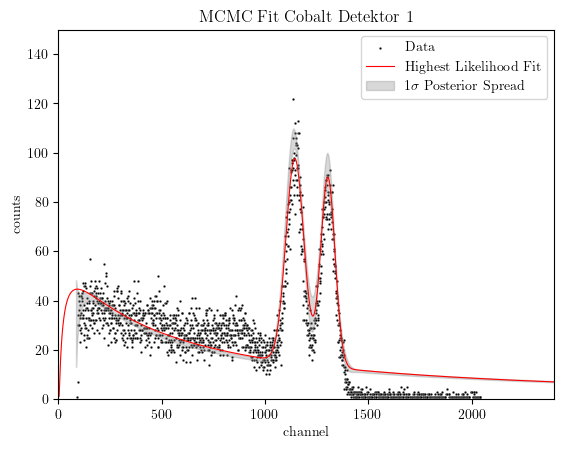

Hyperparameter: 
 [7.41250255e+00 1.14454614e+03 1.30406680e+03 1.71020747e+00
 4.35130850e+01 3.47581022e+01 7.34366194e+04 3.12543800e+00
 9.04849844e+03 6.70466146e+03]


In [5]:
# reading data
df = pd.read_csv('Results/energiespektrum_cobalt_detektor1.asc')
df.columns = ['counts']
df.index.name = 'channel'
df['counts'] = df.loc[df['counts'] > 0]

#------------------------------------------------------------------------------------------------------------
# model building

def model(theta,ch=df.index):
    mu1,mu2,mu3,sig1,sig2,sig3,a1,b1,a2,a3 = theta
    lognormal1 = np.divide(1,(ch-b1)*sig1*np.sqrt(2*np.pi)) * np.exp(-np.divide(np.power(np.log(ch-b1)-mu1,2),2*sig1**2))
    gaussian2 = np.divide(1,sig2*np.sqrt(2*np.pi)) * np.exp(- ( (ch-mu2) /sig2 )**2 / 2)
    gaussian3 = np.divide(1,sig3*np.sqrt(2*np.pi)) * np.exp(- ( (ch-mu3) /sig3 )**2 / 2)
    return a1*lognormal1 + a2*gaussian2 + a3*gaussian3 

def lnlike(theta, ch, value, value_err):
    return -0.5 * np.sum(((value - model(theta, ch))/value_err) ** 2)

def lnprior(theta):
    mu1,mu2,mu3,sig1,sig2,sig3,a1,b1,a2,a3 = theta
    if 0.0 < mu1 < 10.0 and 1100.0 < mu2 < 1200.0 and 1250.0 < mu3 < 1350.0 and 0.0 < sig1 < 3.0 and 0.0 < sig2 < 50.0 and 0.0 < sig3 < 50.0 and 5000 < a1 < 8e4 and 0 < b1 < 200 and 0.0 < a2 < 2e4 and 0.0 < a3 < 1e4:
        return 0.0
    return -np.inf

def lnprob(theta, ch, value, value_err):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, ch, value, value_err)

count_err = 0.05*df['counts'].mean() # arbitrary error bar; we may need to look at the precision of the TSCA
data = (df.index, df['counts'], count_err)
initial = np.array([6.5, 1150.0, 1300.0, 1.0, 50.0, 50.0, 75000.0, 0.0 , 1e4, 7000.0])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

def main(p0,nwalkers,niter,ndim,lnprob,data):
    start = time.time()
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)
    print("Starting burn-in period")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()
    print("Burn-in period complete")
    print("Starting chains") # this will take 1-5 minutes depending on the size of the walkers and iterations
    pos, prob, state = sampler.run_mcmc(p0, niter)
    print("...Complete!")
    
    end = time.time()
    print("Time required:  ",end - start)
    return sampler, pos, prob, state

sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

def mcmcplot(sampler,ch=df.index,val=df['counts']):
    plt.ion()
    sns.scatterplot(x=ch,y=val, s=3, color='k', label='Data')
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(ch, model(theta, ch), color="r", alpha=0.1, linewidth=.5)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('channel')
    plt.ylabel('counts')
    ax = plt.gca()
    ax.set_xlim([0,2400])
    ax.set_ylim([0,150])
    plt.title("MCMC Ketten (rot) Cobalt Detektor 1")
    plt.legend()
    plt.savefig("plots/MCMC Cobalt Detektor 1 Chains.pdf")
    plt.show()

mcmcplot(sampler)

samples = sampler.flatchain
hyperparameter_co1 = samples[np.argmax(sampler.flatlnprobability)] # fitted hyperparameter with best values
mcmcfit = model(hyperparameter_co1)

#------------------------------------------------------------------------------------------------------------
# diagnosis corner plot

labels = ['mu1','mu2','mu3','sig1','sig2','sig3','a1','b1','a2','a3']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])
plt.savefig("plots/MCMC Cobalt Detektor 1 Hyperparameters.pdf")
plt.show()

#------------------------------------------------------------------------------------------------------------
# result plot

def sample_walkers(nsamples,flattened_chain):
    models = []
    draw = np.floor(np.random.uniform(0,len(flattened_chain),size=nsamples)).astype(int)
    thetas = flattened_chain[draw]
    for i in thetas:
        mod = model(i)
        models.append(mod)
    spread = np.std(models,axis=0)
    med_model = np.median(models,axis=0)
    return med_model,spread
med_model, spread = sample_walkers(100,samples)

sns.scatterplot(x=df.index,y=df['counts'], s=3, color='k', label='Data')
plt.plot(df.index,mcmcfit, color='r',linewidth=.8, label='Highest Likelihood Fit')
plt.fill_between(df.index,med_model-spread,med_model+spread,color='grey',alpha=0.3,label=r'$1\sigma$ Posterior Spread')
plt.xlabel('channel')
plt.ylabel('counts')
ax = plt.gca()
ax.set_xlim([0,2400])
ax.set_ylim([0,150])
plt.title("MCMC Fit Cobalt Detektor 1")
plt.legend()
plt.savefig("plots/MCMC Cobalt Detektor 1 Fit.pdf")
plt.show()
print('Hyperparameter: \n',hyperparameter_co1)

## Cobalt at detector 2
This time, the lower-value spectrum has a short tail. In this case, we better fit it with a gamma distribution or a custom exponential function. \
We choose two additional custom exponential functions, as there four peaks to be seen: two at the cascade peaks and two at lower values. 

Starting burn-in period
Burn-in period complete
Starting chains
...Complete!
Time required:   70.98698449134827


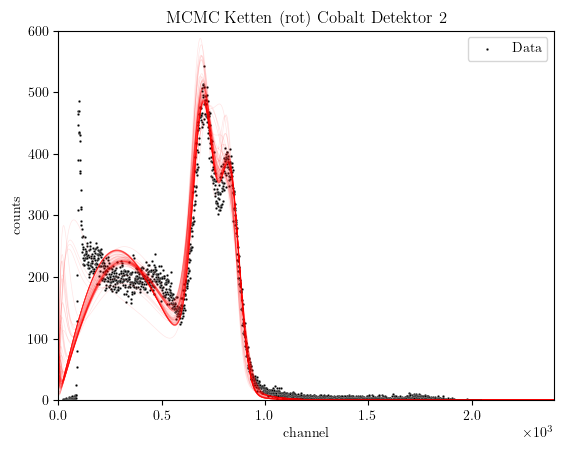

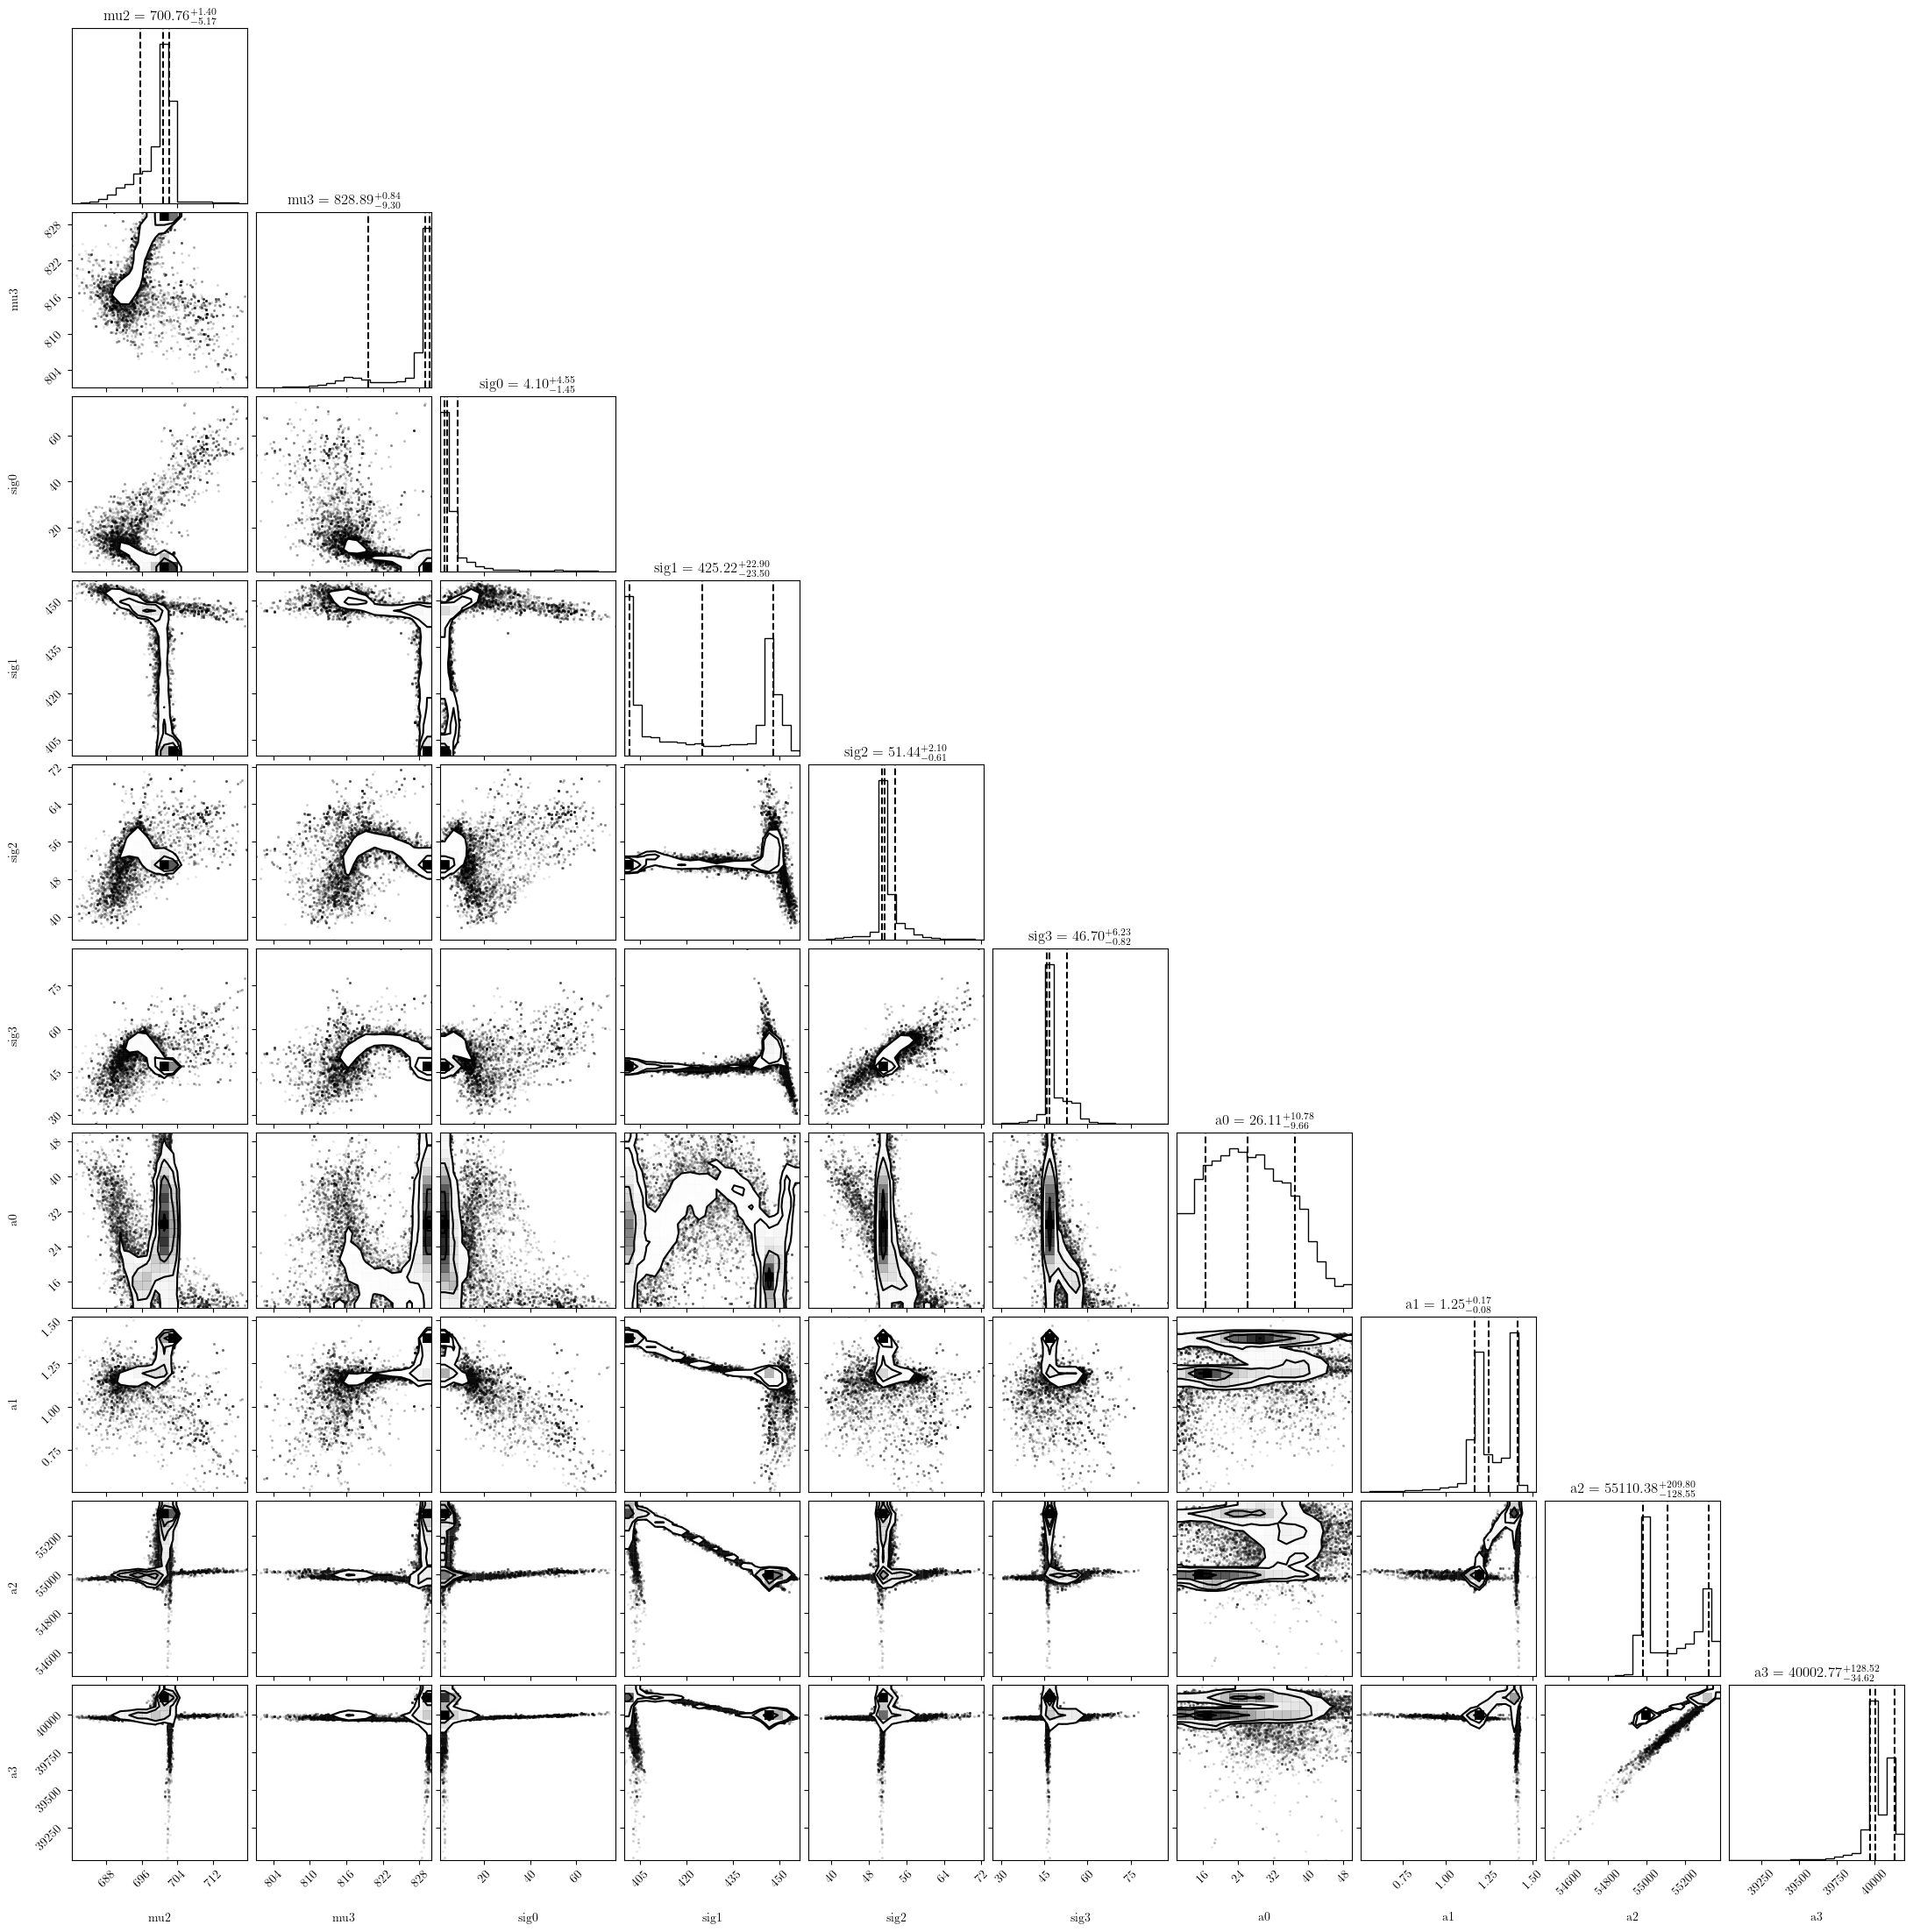

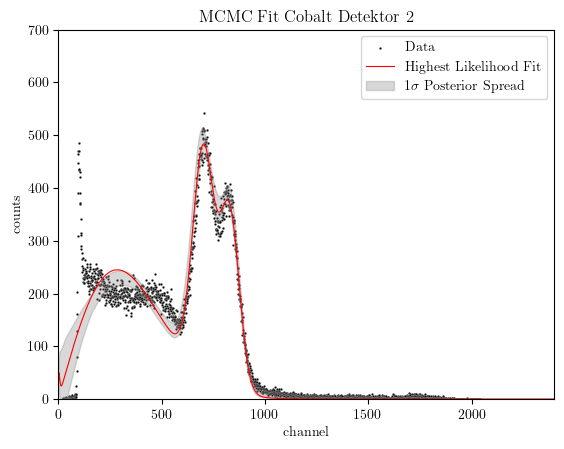

Hyperparameter: 
 [7.02318660e+02 8.28792060e+02 2.94943169e+00 4.03229411e+02
 5.09997700e+01 4.67660421e+01 4.21838723e+01 1.41628176e+00
 5.45937084e+04 3.92014646e+04]


In [6]:
# reading data
df = pd.read_csv('Results/energiespektrum_cobalt_detektor2.asc')
df.columns = ['counts']
df.index.name = 'channel'
df['counts'] = df.loc[df['counts'] > 0]

#------------------------------------------------------------------------------------------------------------
# model building

def model(theta,ch=df.index):
    mu2,mu3,sig0,sig1,sig2,sig3,a0,a1,a2,a3 = theta
    # lognormal1 = np.divide(1,(ch-b1)*sig1*np.sqrt(2*np.pi)) * np.exp(-np.divide(np.power(np.log(ch-b1)-mu1,2),2*sig1**2))
    exp0 = ch*np.exp(-ch/sig0)
    exp1 = ch*np.exp(-(ch/sig1)**2)
    gaussian2 = np.divide(1,sig2*np.sqrt(2*np.pi)) * np.exp(- ( (ch-mu2) /sig2 )**2 / 2)
    gaussian3 = np.divide(1,sig3*np.sqrt(2*np.pi)) * np.exp(- ( (ch-mu3) /sig3 )**2 / 2)
    return a0*exp0 + a1*exp1 + a2*gaussian2 + a3*gaussian3 

def lnlike(theta, ch, value, value_err):
    return -0.5 * np.sum(((value - model(theta, ch))/value_err) ** 2)

def lnprior(theta):
    mu2,mu3,sig0,sig1,sig2,sig3,a0,a1,a2,a3 = theta
    if 680.0 < mu2 < 720.0 and 790.0 < mu3 < 830.0 and 1.0 < sig0 < 100.0 and 400.0 < sig1 < 1000.0 and 0.0 < sig2 < 150.0 and 0.0 < sig3 < 150.0 and 10.0 < a0 < 50.0 and 0.5 < a1 < 10.0 and 0.0 < a2 < 7e4 and 0.0 < a3 < 6e4:
        return 0.0
    return -np.inf

def lnprob(theta, ch, value, value_err):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, ch, value, value_err)

count_err = 0.05*df['counts'].mean() # arbitrary error bar; we may need to look at the precision of the TSCA
data = (df.index, df['counts'], count_err)
initial = np.array([700.0, 815.0, 50.0 , 450.0, 50.0, 50.0, 30.0, 1.0, 5.5e4, 4e4])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

def main(p0,nwalkers,niter,ndim,lnprob,data):
    start = time.time()
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)
    print("Starting burn-in period")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()
    print("Burn-in period complete")
    print("Starting chains") # this will take 1-5 minutes depending on the size of the walkers and iterations
    pos, prob, state = sampler.run_mcmc(p0, niter)
    print("...Complete!")
    
    end = time.time()
    print("Time required:  ",end - start)
    return sampler, pos, prob, state

sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

def mcmcplot(sampler,ch=df.index,val=df['counts']):
    plt.ion()
    sns.scatterplot(x=ch,y=val, s=3, color='k', label='Data')
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(ch, model(theta, ch), color="r", alpha=0.1, linewidth=.5)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('channel')
    plt.ylabel('counts')
    ax = plt.gca()
    ax.set_xlim([0,2400])
    ax.set_ylim([0,600])
    plt.title("MCMC Ketten (rot) Cobalt Detektor 2")
    plt.legend()
    plt.savefig("plots/MCMC Cobalt Detektor 2 Chains.pdf")
    plt.show()

mcmcplot(sampler)

samples = sampler.flatchain
hyperparameter_co2 = samples[np.argmax(sampler.flatlnprobability)] # fitted hyperparameter with best values
mcmcfit = model(hyperparameter_co2)

#------------------------------------------------------------------------------------------------------------
# diagnosis corner plot

labels = ['mu2','mu3','sig0','sig1','sig2','sig3','a0','a1','a2','a3']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])
plt.savefig("plots/MCMC Cobalt Detektor 2 Hyperparameters.pdf")
plt.show()

#------------------------------------------------------------------------------------------------------------
# result plot

def sample_walkers(nsamples,flattened_chain):
    models = []
    draw = np.floor(np.random.uniform(0,len(flattened_chain),size=nsamples)).astype(int)
    thetas = flattened_chain[draw]
    for i in thetas:
        mod = model(i)
        models.append(mod)
    spread = np.std(models,axis=0)
    med_model = np.median(models,axis=0)
    return med_model,spread
med_model, spread = sample_walkers(100,samples)

sns.scatterplot(x=df.index,y=df['counts'], s=3, color='k', label='Data')
plt.plot(df.index,mcmcfit, color='r',linewidth=.8, label='Highest Likelihood Fit')
plt.fill_between(df.index,med_model-spread,med_model+spread,color='grey',alpha=0.3,label=r'$1\sigma$ Posterior Spread')
plt.xlabel('channel')
plt.ylabel('counts')
ax = plt.gca()
ax.set_xlim([0,2400])
ax.set_ylim([0,700])
plt.title("MCMC Fit Cobalt Detektor 2")
plt.legend()
plt.savefig("plots/MCMC Cobalt Detektor 2 Fit.pdf")
plt.show()
print('Hyperparameter: \n',hyperparameter_co2)

## Linear regression of the peaks $\&$ energy calibration

Detector|sodium 511keV|sodium 1275keV|cobalt 1173.2keV|cobalt 1332.5keV|
:-|-|-|-|-|
D1|480|1260|1150|1300|
D2|205|790|700|810|

We capitalize on the fact that the channel value of the TSCA is linear proportional to the energy values to an accuracy of 1keV ["Grundlagen_gamma_FP16" page 46]:
$$
    E_\gamma = a + b \cdot K .
$$
This means that the difference in energies should be the same as the difference in channel values to a factor $b$ 
\begin{align}
    \Delta E_{\gamma} &= b \Delta K \\
    b &= \frac{\Delta E_{\gamma}}{\Delta K}
\end{align}
For the difference, we use the two peaks of the spectra. In theory, a third peak should arise from compton scattering, which could increase the precision of our calibration. But those peaks were hard to observe. In case of detector 2, we don't know for sure whether the peak at lower channel values is physical or not just some artifact. \
We can determine $a$ by inserting any matching pair of channel value and energy peak, i.e. 480 and 511 for sodium at detector 1.

## Error propagation

For the uncertainty of the peaks, we take the gaussian standard deviation value from the hyperparameterset.
Value ($MeV$)| K$_1$ |$\sigma_1$|K$_2$|$\sigma_2$|
:-|-|-|-|-|
Sodium D1|483.965|15.8|1259.43|51.25|
Sodium D2|201.54|28.91|703.413883|48.78|
Cobalt D1|1143.162596|39.92|1301.708396|34.81|
Cobalt D2|703.413883|50.97|829.951054|46.65|

The calibration values $a$ and $b$ have an uncertainty which is determined via error propagation: \
\begin{align}
    b                &= \frac{\Delta E_\gamma}{\Delta K} \\
    \Delta b         &=  \sqrt{ \left ( \frac{\partial b}{\partial (\Delta K)}\Delta(\Delta K) \right )^2 } \\
                     &= \frac{\Delta E_{\gamma}}{(\Delta K)^2}\Delta (\Delta K) \\
    \Delta(\Delta K) &= \sqrt{ \left( \frac{\partial(\Delta K)}{\partial K_1} \sigma_1 \right)^2 + 
        \left( \frac{\partial(\Delta K)}{\partial K_2} \sigma_2 \right)^2} \\
                     &= \sqrt{\sigma_1^2 + \sigma_2^2}\\
    a                &= E_{\gamma} - b \cdot K \\
    \Delta a         &= \sqrt{ \left( \frac{\partial a}{\partial b} \Delta b \right)^2 + 
        \left( \frac{\partial a}{\partial K} \sigma \right)^2  } \\
                     &= \sqrt{ \left( K \cdot \Delta b \right)^2 + \left( b \cdot \sigma \right)^2 }
\end{align}

In [56]:
multiindex = [
    ["E", "E", "D1", "D1", "D2", "D2"],
    ["p1", "p2","p1", "p2", "p1", "p2"],
]
tuples = list(zip(*multiindex))
index = pd.MultiIndex.from_tuples(tuples, names=["Theoretical / Detector","Peak"])
source = pd.DataFrame({"na":[511,1275,hyperparameter_na1[1],hyperparameter_na1[2],hyperparameter_na2[1],hyperparameter_na2[2]],
                       "na sigma": [0,0,hyperparameter_na1[4],hyperparameter_na1[5],hyperparameter_na2[4],hyperparameter_na2[5]],
                       "co":[1173.2,1332.5,hyperparameter_co1[1],hyperparameter_co1[2],hyperparameter_co2[0],hyperparameter_co2[1]],
                       "co sigma":[0,0,hyperparameter_co1[4],hyperparameter_co1[5],hyperparameter_co2[4],hyperparameter_co2[5]]}, index=index)
ic(source)
def peak(d,p,s):
    '''
    d: E, D1 or D2
    p: p1 or p2
    s: na or co
    example use: ic(peak('D1','p1','na'))
    '''
    return float(source.loc[(d,p),s])


ic| source:                                       na   na sigma           co   co sigma
            Theoretical / Detector Peak                                                
            E                      p1     511.000000   0.000000  1173.200000   0.000000
                                   p2    1275.000000   0.000000  1332.500000   0.000000
            D1                     p1     482.416601  21.966744  1144.546141  43.513085
                                   p2    1257.049800  32.890350  1304.066797  34.758102
            D2                     p1     201.397352  28.667668   702.318660  50.999770
                                   p2     783.274585  49.997094   828.792060  46.766042


In [65]:
# for latex
latex_table = source.to_latex(
    # index=False,  
    caption="Peaks im Spektrum",  # The caption to appear above the table in the LaTeX document
    label="tab:peaks",  # A label used for referencing the table within the LaTeX document
    position="ht",  # The preferred positions where the table should be placed in the document ('here', 'top', 'bottom', 'page')
    column_format="llrr",  # The format of the columns: left-aligend first column and center-aligned remaining columns as per APA guidelines
    escape=False,  
    float_format="{:0.4f}".format  
)

print(latex_table)

\begin{table}[ht]
\caption{Peaks im Spektrum}
\label{tab:peaks}
\begin{tabular}{llrr}
\toprule
 &  & na & na sigma & co & co sigma \\
Theoretical / Detector & Peak &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{E} & p1 & 511.0000 & 0.0000 & 1173.2000 & 0.0000 \\
 & p2 & 1275.0000 & 0.0000 & 1332.5000 & 0.0000 \\
\cline{1-6}
\multirow[t]{2}{*}{D1} & p1 & 482.4166 & 21.9667 & 1144.5461 & 43.5131 \\
 & p2 & 1257.0498 & 32.8904 & 1304.0668 & 34.7581 \\
\cline{1-6}
\multirow[t]{2}{*}{D2} & p1 & 201.3974 & 28.6677 & 702.3187 & 50.9998 \\
 & p2 & 783.2746 & 49.9971 & 828.7921 & 46.7660 \\
\cline{1-6}
\bottomrule
\end{tabular}
\end{table}



In [58]:
# error calculation

# values for error
na1_d1 = hyperparameter_na1[1]
na1_d1_sig = hyperparameter_na1[4]
na2_d1 = hyperparameter_na1[2]
na2_d1_sig = hyperparameter_na1[5]

na1_d2 = hyperparameter_na2[1]
na1_d2_sig = hyperparameter_na2[4]
na2_d2 = hyperparameter_na2[2]
na2_d2_sig = hyperparameter_na2[5]

co1_d1 = hyperparameter_co1[1]
co1_d1_sig = hyperparameter_co1[4]
co2_d1 = hyperparameter_co1[2]
co2_d1_sig = hyperparameter_co1[5]

co1_d2 = hyperparameter_co2[0]
co1_d2_sig = hyperparameter_co2[4]
co2_d2 = hyperparameter_co2[1]
co2_d2_sig = hyperparameter_co2[5]


def delta_delta_K(sig1, sig2):
    return np.sqrt(sig1**2 + sig2**2)

def delta_b(ch1, ch2, sig1, sig2, so=True):
    if so==True:
        delta_E_na = peak('E','p2','na') - peak('E','p1','na')
        delta_K = ch2 - ch1
        b = delta_E_na / delta_K
        deltab = ( delta_E_na * delta_delta_K(sig1, sig2))/ delta_K**2
    else:
        delta_E_co = peak('E','p2','co') - peak('E','p1','co')
        delta_K = ch2 - ch1
        b = delta_E_co / delta_K
        deltab = ( delta_E_co * delta_delta_K(sig1, sig2))/ delta_K**2
    return b, deltab

ic(delta_b(na1_d1, na2_d1, na1_d1_sig, na2_d1_sig))
ic(delta_b(na1_d2, na2_d2, na1_d2_sig, na1_d2_sig))
ic(delta_b(co1_d1, co2_d1, co1_d1_sig, co2_d1_sig, so="co"))
ic(delta_b(co1_d2, co2_d2, co1_d2_sig, co2_d2_sig, so="co"))


def delta_a(ch1,ch2,sig1,sig2, so=True):
    if so==True:
        delta_E_na = peak('E','p2','na') - peak('E','p1','na')
        delta_K = ch2 - ch1
        b = delta_E_na / delta_K
        a = peak('E','p1','na') - (b * ch1)
        # ic(a)
        # ic((ch1*delta_b(ch1,ch2,sig1,sig2,so=True))**2)
        # ic((b*sig1)**2)
        # ic((ch1*delta_b(ch1,ch2,sig1,sig2,so=True))**2 + (b*sig1)**2)
        deltaa = np.sqrt( (ch1*delta_b(ch1,ch2,sig1,sig2,so=True)[1])**2 + (b*sig1)**2 )
        return a, deltaa
    else:
        delta_E_co = peak('E','p2','co') - peak('E','p1','co')
        delta_K = ch2 - ch1
        b = delta_E_co / delta_K
        a = peak('E','p1','co') - (b * ch1)
        deltaa = np.sqrt( (ch1 * delta_b(ch1, ch2, sig1, sig2, so=False)[1])**2 + (b*sig1)**2 )
        return a, deltaa
'''
def delta_a(ch1,ch2,sig1,sig2, so=True):
    if so==True:
        delta_E_na = peak('E','p2','na') - peak('E','p1','na')
        delta_K = ch2 - ch1
        b = delta_E_na / delta_K
        a = peak('E','p1','na') - (b * ch1)
        ic(a)
        return np.sqrt((b*sig1)**2 )
    else:
        delta_E_co = peak('E','p2','co') - peak('E','p1','co')
        delta_K = ch2 - ch1
        b = delta_E_co / delta_K
        a = peak('E','p1','co') - (b * ch1)
        ic(a)
        return np.sqrt( (b*sig1)**2 )
'''

ic("na d1")
ic(delta_a(na1_d1, na2_d1, na1_d1_sig, na2_d1_sig))
ic("na d2")
ic(delta_a(na1_d2, na2_d2, na1_d2_sig, na1_d2_sig))
ic("co d1",)
ic(delta_a(co1_d1, co2_d1, co1_d1_sig, co2_d1_sig, False))
ic("co d2")
ic(delta_a(co1_d2, co2_d2, co1_d2_sig, co2_d2_sig, False))

ic| delta_b(na1_d1, na2_d1, na1_d1_sig, na2_d1_sig): (0.9862732471805753, 0.05035736213857419)
ic| delta_b(na1_d2, na2_d2, na1_d2_sig, na1_d2_sig): (1.3129917396515352, 0.09148249343246283)
ic| delta_b(co1_d1, co2_d1, co1_d1_sig, co2_d1_sig, so="co"): (0.9986167562190993, 0.34863325552770724)
ic| delta_b(co1_d2, co2_d2, co1_d2_sig, co2_d2_sig, so="co"): (1.259553391950069, 0.6891221952635183)
ic| 'na d1'
ic| delta_a(na1_d1, na2_d1, na1_d1_sig, na2_d1_sig): (35.205412332313585, 32.550611703243455)
ic| 'na d2'
ic| delta_a(na1_d2, na2_d2, na1_d2_sig, na1_d2_sig): (246.56694045068002, 41.90771489803014)
ic| 'co d1'
ic| delta_a(co1_d1, co2_d1, co1_d1_sig, co2_d1_sig, False): (30.237045572154784, 401.3858229973648)
ic| 'co d2'
ic| delta_a(co1_d2, co2_d2, co1_d2_sig, co2_d2_sig, False): (288.5921495414, 488.2277056735431)


(288.5921495414, 488.2277056735431)

In [59]:
b_D1_na = delta_b(na1_d1, na2_d1, na1_d1_sig, na2_d1_sig)[0]
delta_b_D1_na = delta_b(na1_d1, na2_d1, na1_d1_sig, na2_d1_sig)[1]
a_D1_na = delta_a(na1_d1, na2_d1, na1_d1_sig, na2_d1_sig)[0]
delta_a_D1_na = delta_a(na1_d1, na2_d1, na1_d1_sig, na2_d1_sig)[1]

b_D2_na = delta_b(na1_d2, na2_d2, na1_d2_sig, na1_d2_sig)[0]
delta_b_D2_na = delta_b(na1_d2, na2_d2, na1_d2_sig, na1_d2_sig)[1]
a_D2_na = delta_a(na1_d2, na2_d2, na1_d2_sig, na1_d2_sig)[0]
delta_a_D2_na = delta_a(na1_d2, na2_d2, na1_d2_sig, na1_d2_sig)[1]

b_D1_co = delta_b(co1_d1, co2_d1, co1_d1_sig, co2_d1_sig, so="co")[0]
delta_b_D1_co = delta_b(co1_d1, co2_d1, co1_d1_sig, co2_d1_sig, so="co")[1]
a_D1_co = delta_a(co1_d1, co2_d1, co1_d1_sig, co2_d1_sig, False)[0]
delta_a_D1_co = delta_a(co1_d1, co2_d1, co1_d1_sig, co2_d1_sig, False)[1]

b_D2_co = delta_b(co1_d2, co2_d2, co1_d2_sig, co2_d2_sig, so="co")[0]
delta_b_D2_co = delta_b(co1_d2, co2_d2, co1_d2_sig, co2_d2_sig, so="co")[1]
a_D2_co = delta_a(co1_d2, co2_d2, co1_d2_sig, co2_d2_sig, False)[0]
delta_a_D2_co = delta_a(co1_d2, co2_d2, co1_d2_sig, co2_d2_sig, False)[1]

In [67]:
# error bar for calibration curves. We calculate the errors of specific calibrated values, i.e. the peaks 
# done for sodium
D1_DE_p1 = np.sqrt( (delta_a_D1_na)**2 + (b_D2_na*na1_d1_sig)**2 + (na1_d1*delta_b_D1_na)**2 )
ic(D1_DE_p1)
D1_DE_p2 = np.sqrt( (delta_a_D1_na)**2 + (b_D1_na*na2_d1_sig)**2 + (na2_d1*delta_b_D1_na)**2 )
ic(D1_DE_p2)

D2_DE_p1 = np.sqrt( (delta_a_D2_na)**2 + (b_D2_na*na1_d2_sig)**2 + (na1_d2*delta_b_D2_na)**2 )
ic(D2_DE_p1)
D2_DE_p2 = np.sqrt( (delta_a_D2_na)**2 + (b_D2_na*na2_d2_sig)**2 + (na2_d2*delta_b_D2_na)**2 )
ic(D2_DE_p2)

ic| D1_DE_p1: 49.815389789006865
ic| D1_DE_p2: 78.22358662381761
ic| D2_DE_p1: 59.26645877685924
ic| D2_DE_p2: 105.83096716353246


105.83096716353246

ic| calibrate('D1','na',hyperparameter_na1[1]): 511.0
ic| na1_d2: 201.39735198905353
ic| calibrate('D2','na',na1_d2): 511.0


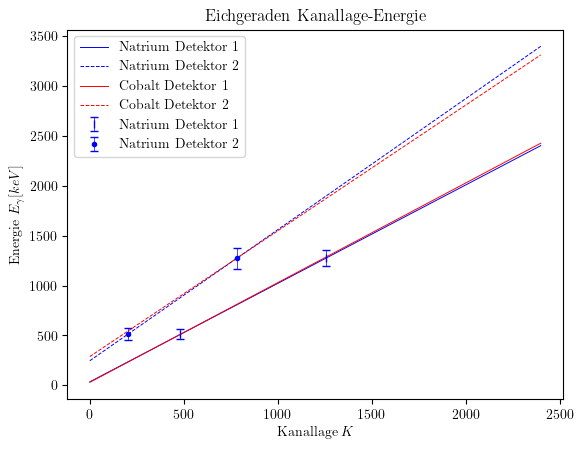

In [61]:
'''
delta_E_na = peak('E','p2','na') - peak('E','p1','na') # Delta E

delta_D1_na = peak('D1','p2','na') - peak('D1','p1','na') # Delta K

b_D1_na = delta_E_na / delta_D1_na # determine b
a_D1_na = peak('E','p1','na') - b_D1_na * peak('D1','p1','na') # determine a

delta_D2_na = peak('D2','p2','na') - peak('D2','p1','na')
b_D2_na = delta_E_na / delta_D2_na 
a_D2_na = peak('E','p1','na') - b_D2_na * peak('D2','p1','na')


delta_E_co = peak('E','p2','co') - peak('E','p1','co')

delta_D1_co = peak('D1','p2','co') - peak('D1','p1','co') 
b_D1_co = delta_E_co / delta_D1_co
a_D1_co = peak('E','p1','co') - b_D1_co * peak('D1','p1','co')

delta_D2_co = peak('D2','p2','co') - peak('D2','p1','co')
b_D2_co = delta_E_co / delta_D2_co 
a_D2_co = peak('E','p1','co') - b_D2_co * peak('D2','p1','co')
'''

multiindex2 = [
    ["D1", "D1", "D2", "D2"],
    ["a", "b", "a", "b"],
]
tuples = list(zip(*multiindex2))
index2 = pd.MultiIndex.from_tuples(tuples, names=["Detector","Calibration value"])
calibration = pd.DataFrame({"na":[a_D1_na,b_D1_na,a_D2_na,b_D2_na],
                            "na error":[delta_a_D1_na,delta_b_D1_na,delta_a_D2_na,delta_b_D2_na],
                       "co":[a_D1_co,b_D1_co,a_D2_co,b_D2_co],
                           "co error":[delta_a_D1_co,delta_b_D1_co,delta_a_D2_co,delta_b_D2_co]}, index=index2)


def calibrate(d,s,ch):
    '''
    d: detector, D1 or D2 
    s: source, na or co
    ch: channel value, float
    '''
    a = calibration.loc[(d,'a'),s]
    b = calibration.loc[(d,'b'),s]
    E = a + b*ch
    return E
ic(calibrate('D1','na',hyperparameter_na1[1])) # test

x_error_points = [na1_d1, na2_d1]
y_error_points = [calibrate('D1','na',na1_d1), calibrate('D1','na',na2_d1)]
y_errors = [D1_DE_p1, D1_DE_p2]

x_error_points2 = [na1_d2, na2_d2]
y_error_points2 = [calibrate('D2','na',na1_d2), calibrate('D2','na',na2_d2)]
y_errors2 = [D2_DE_p1, D2_DE_p2]
ic(na1_d2)
ic(calibrate('D2','na',na1_d2))

ch = np.linspace(0,2400,1000)
fig, ax = plt.subplots()
ax.plot(ch, calibrate('D1','na',ch), 'b', linewidth=.7, label='Natrium Detektor 1')
ax.errorbar(x_error_points, y_error_points, yerr=y_errors, fmt='|', capsize=3, color='b',linewidth=.5, label='Natrium Detektor 1')
ax.plot(ch, calibrate('D2','na',ch), 'b--', linewidth=.7,label='Natrium Detektor 2')
ax.errorbar(x_error_points2, y_error_points2, yerr=y_errors2, fmt='.', capsize=3, color='b',linewidth=.5, label='Natrium Detektor 2')
ax.plot(ch, calibrate('D1','co',ch), 'r', linewidth=.7,label='Cobalt Detektor 1')
ax.plot(ch, calibrate('D2','co',ch), 'r--', linewidth=.7,label='Cobalt Detektor 2')
ax.set_title('Eichgeraden Kanallage-Energie')
ax.set(xlabel=f'Kanallage $K$', ylabel=f'Energie $E_\\gamma [keV]$ ')
ax.legend()
plt.savefig("plots/Eichgeraden.pdf")
plt.show()

In [62]:
## for latex
ic(calibration)

latex_table = calibration.to_latex(
    # index=False,  
    caption="Parameter der Kalibration",  # The caption to appear above the table in the LaTeX document
    label="tab:calibration",  # A label used for referencing the table within the LaTeX document
    position="ht",  # The preferred positions where the table should be placed in the document ('here', 'top', 'bottom', 'page')
    column_format="llrrrr",  # The format of the columns: left-aligend first column and center-aligned remaining columns as per APA guidelines
    escape=False,  
    float_format="{:0.4f}".format  
)
print(latex_table)

ic| calibration:                                     na   na error          co    co error
                 Detector Calibration value                                               
                 D1       a                   35.205412  32.550612   30.237046  401.385823
                          b                    0.986273   0.050357    0.998617    0.348633
                 D2       a                  246.566940  41.907715  288.592150  488.227706
                          b                    1.312992   0.091482    1.259553    0.689122


\begin{table}[ht]
\caption{Parameter der Kalibration}
\label{tab:calibration}
\begin{tabular}{llrrrr}
\toprule
 &  & na & na error & co & co error \\
Detector & Calibration value &  &  &  &  \\
\midrule
\multirow[t]{2}{*}{D1} & a & 35.2054 & 32.5506 & 30.2370 & 401.3858 \\
 & b & 0.9863 & 0.0504 & 0.9986 & 0.3486 \\
\cline{1-6}
\multirow[t]{2}{*}{D2} & a & 246.5669 & 41.9077 & 288.5921 & 488.2277 \\
 & b & 1.3130 & 0.0915 & 1.2596 & 0.6891 \\
\cline{1-6}
\bottomrule
\end{tabular}
\end{table}



In [63]:
# Sodium Calibration
delta_E_D1_peak1 = np.sqrt( (delta_a_D1_na)**2 + (b_D1_na * na1_d1_sig)**2 + (na1_d1 * delta_b_D1_na)**2 )
ic(calibrate('D1','na',hyperparameter_na1[1]))
ic(delta_E_D1_peak1)

ic| calibrate('D1','na',hyperparameter_na1[1]): 511.0
ic| delta_E_D1_peak1: 46.03351653426729


46.03351653426729

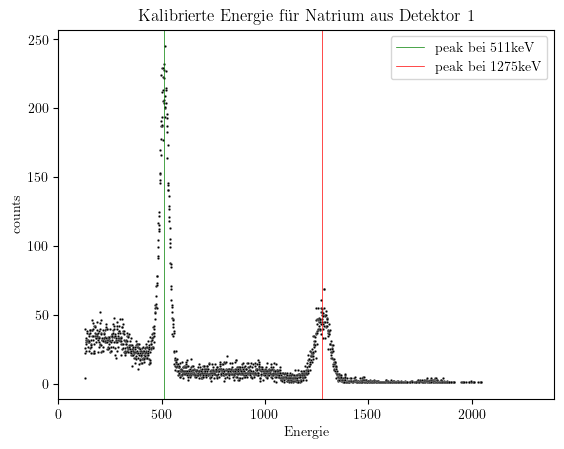

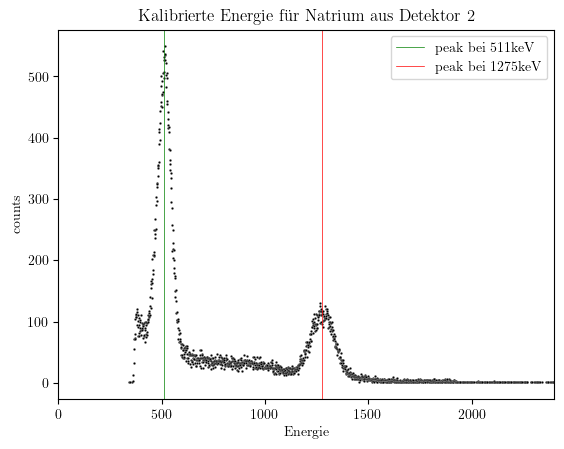

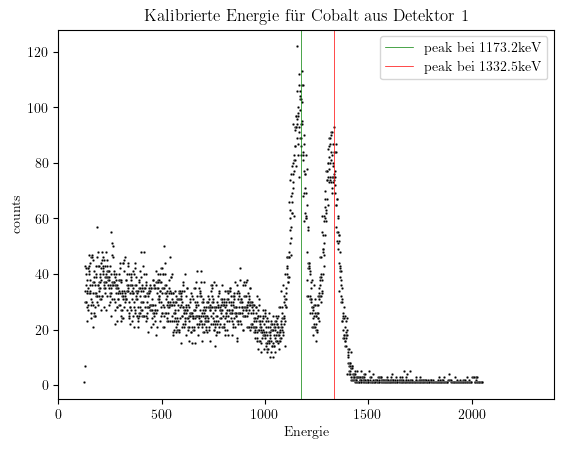

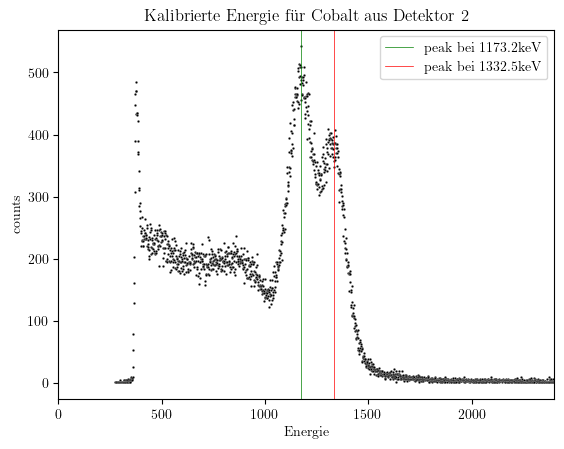

In [64]:
def calibratedenergy(source, detector, data, title, peak1, peak2):
    '''
        detector (string): D1 or D2
        source (string): na or co
        data (string): csv file
        color: b, b--, r, r--
        title (string)
        filename (string)
    '''
    df = pd.read_csv(data)
    df.columns = ['counts']
    df.index.name = 'channel'
    df['counts'] = df.loc[df['counts'] > 0]
    energy = calibrate(detector,source, df.index)
    
    fig, ax = plt.subplots()
    sns.scatterplot(x=energy, y=df['counts'], s=3, color='k')
    ax.set_title(f"Kalibrierte Energie für {title}")
    ax.set(xlabel='Energie', ylabel='counts')
    ax.set_xlim([0,2400])
    plt.axvline(peak1, linewidth=.5, c='g', label=f'peak bei {peak1}keV')
    plt.axvline(peak2, linewidth=.5, c='r', label=f'peak bei {peak2}keV')
    plt.legend()
    plt.savefig(f"plots/Kalibriertes Energiegesamtspektrum von {title}.pdf")
    plt.show()

calibratedenergy('na', 'D1', 'Results/energiespektrum_natrium_detektor1.asc', 'Natrium aus Detektor 1', 511,1275)
calibratedenergy('na', 'D2', 'Results/energiespektrum_natrium_detektor2.asc', 'Natrium aus Detektor 2', 511,1275)
calibratedenergy('na', 'D1', 'Results/energiespektrum_cobalt_detektor1.asc', 'Cobalt aus Detektor 1', 1173.2,1332.5)
calibratedenergy('na', 'D2', 'Results/energiespektrum_cobalt_detektor2.asc', 'Cobalt aus Detektor 2', 1173.2,1332.5)